# Make a chi2 spectrum fit with mixed Fermi/HGPS data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pprint import pprint
import astropy.units as u
from astropy.units import Quantity

## The source

~~I'm selecting HESS J1614-518 (source_id 83) / 3FGL J1615.3-5146e.~~

I'm selecting HESS J1303-631 (source_id 61) / 3FGL J1303.0-6312e.

\*\*Many sources from gamma-cat do not have filled in flux data yet (e.g. source_id 83) - I can only work with a select amount of sources until the HGPS catalog is made available to the public.

See from the [Fermi-HGPS repo](https://github.com/gammasky/fermi-hgps-paper/blob/master/analysis/plots/seds/HESS%20J1614-518_3FGL%20J1615.3-5146e_sed.png).

In [2]:
from gammapy.catalog import SourceCatalog3FGL, SourceCatalogObject3FGL, SourceCatalogHGPS, SourceCatalogObjectHGPS, SourceCatalogGammaCat, SourceCatalogObjectGammaCat

cat_3fgl = SourceCatalog3FGL()
# cat_hgps = SourceCatalogHGPS()  <-- Use gamma-cat until this is made available
cat_gammacat = SourceCatalogGammaCat()

source_3fgl = cat_3fgl['3FGL J1615.3-5146e']
source_gammacat = cat_gammacat['HESS J1303-631']

data_3fgl = source_3fgl.flux_points.table
data_gammacat = source_gammacat.flux_points.table

# Flux units - gamma-cat must be converted from TeV to MeV to match 3FGL
data_3fgl['dnde'] = data_3fgl['dnde'].to('cm-2 s-1 MeV-1')

data_gammacat['e_ref'] = data_gammacat['e_ref'].to('MeV')
data_gammacat['dnde'] = data_gammacat['dnde'].to('cm-2 s-1 MeV-1')
data_gammacat['dnde_errn'] = data_gammacat['dnde_errn'].to('cm-2 s-1 MeV-1')
data_gammacat['dnde_errp'] = data_gammacat['dnde_errp'].to('cm-2 s-1 MeV-1')

# Create flux error
dnde_err = data_3fgl['dnde'] * (data_3fgl['flux_errn'] / data_3fgl['flux'])
data_3fgl['dnde_err'] = dnde_err.to(data_3fgl['dnde'].unit)

dnde_err = data_gammacat['dnde'] * (data_gammacat['dnde_errn'] / data_gammacat['dnde'])
data_gammacat['dnde_err'] = dnde_err.to(data_gammacat['dnde'].unit)
# ^ Did I do the above correctly?

In [3]:
data_3fgl.info()

print('\n', source_3fgl.spectral_model.parameters)

<Table length=5>
   name     dtype        unit      n_bad
---------- ------- --------------- -----
     e_ref float64             MeV     0
     e_min float64             MeV     0
     e_max float64             MeV     0
      flux float32     1 / (cm2 s)     1
 flux_errn float32     1 / (cm2 s)     1
 flux_errp float32     1 / (cm2 s)     1
     eflux float32   erg / (cm2 s)     1
eflux_errn float32   erg / (cm2 s)     1
eflux_errp float32   erg / (cm2 s)     1
     is_ul    bool                     0
   flux_ul float64     1 / (cm2 s)     4
  eflux_ul float64   erg / (cm2 s)     4
      dnde float64 1 / (cm2 MeV s)     0
  dnde_err float64 1 / (cm2 MeV s)     1

 ParameterList
Parameter(name='index', value=1.8643473386764526, unit=Unit(dimensionless), min=0, max=None, frozen=False)
Parameter(name='amplitude', value=2.872970958356369e-13, unit=Unit("1 / (cm2 MeV s)"), min=0, max=None, frozen=False)
Parameter(name='reference', value=6018.2392578125, unit=Unit("MeV"), min=None, max=Non

In [4]:
data_gammacat.info()

print('\n', source_gammacat.spectral_model.parameters)

<Table length=11>
   name    dtype        unit     
--------- ------- ---------------
    e_ref float32             MeV
     dnde float32 1 / (cm2 MeV s)
dnde_errp float32 1 / (cm2 MeV s)
dnde_errn float32 1 / (cm2 MeV s)
 dnde_err float32 1 / (cm2 MeV s)

 ParameterList
Parameter(name='index', value=1.5, unit=Unit(dimensionless), min=0, max=None, frozen=False)
Parameter(name='amplitude', value=5.600000064359678e-12, unit=Unit("1 / (cm2 s TeV)"), min=0, max=None, frozen=False)
Parameter(name='reference', value=1.0, unit=Unit("TeV"), min=None, max=None, frozen=True)
Parameter(name='lambda_', value=0.12987013308711196, unit=Unit("1 / TeV"), min=0, max=None, frozen=False)

Covariance: [[  4.00000012e-02   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   2.49999998e-25   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.37683698e-03]]


In [5]:
data_gammacat

e_ref,dnde,dnde_errp,dnde_errn,dnde_err
MeV,1 / (cm2 MeV s),1 / (cm2 MeV s),1 / (cm2 MeV s),1 / (cm2 MeV s)
float32,float32,float32,float32,float32
880000.0,4.25e-18,1.09e-18,1.09e-18,1.09e-18
1.29e+06,3.03e-18,4.32e-19,4.31e-19,4.31e-19
1.89e+06,2.22e-18,1.93e-19,1.92e-19,1.92e-19
2.76e+06,7.73e-19,8.9e-20,8.87e-20,8.87e-20
4.04e+06,3.39e-19,4.25e-20,4.23e-20,4.23e-20
5.92e+06,1.52e-19,2.15e-20,2.14e-20,2.14e-20
8.67e+06,7.4e-20,1.07e-20,1.06e-20,1.06e-20
1.27e+07,2e-20,5.28e-21,5.24e-21,5.24e-21


In [6]:
cols = ['e_ref', 'dnde', 'dnde_err']

data_combined = (data_3fgl[cols])
data_combined

e_ref,dnde,dnde_err
MeV,1 / (cm2 MeV s),1 / (cm2 MeV s)
float64,float64,float64
173.205080757,5.38337195757e-15,nan
547.722557505,1.18813486835e-11,5.51518207422e-12
1732.05080757,4.30997640725e-12,3.98011543964e-13
5477.22557505,3.922225789e-13,3.78238657523e-14
31622.7766017,1.12540310392e-14,1.34505086203e-15


## ~~Combining source data~~

~~data_3fgl + data_gammacat = data_combined~~

In [7]:
for row in data_gammacat[cols]:
    new_row = []
    for col in row.as_void():
        new_row.append(col)

    data_combined.add_row(new_row)

data_combined

e_ref,dnde,dnde_err
MeV,1 / (cm2 MeV s),1 / (cm2 MeV s)
float64,float64,float64
173.205080757,5.38337195757e-15,nan
547.722557505,1.18813486835e-11,5.51518207422e-12
1732.05080757,4.30997640725e-12,3.98011543964e-13
5477.22557505,3.922225789e-13,3.78238657523e-14
31622.7766017,1.12540310392e-14,1.34505086203e-15
880000.0,4.25000022056e-18,1.09000008819e-18
1290000.0,3.0300000137e-18,4.30999976629e-19
1890000.0,2.21999994247e-18,1.91999993907e-19


In [8]:
print(source_3fgl.energy_range)

combined_energy_range = Quantity([100, 1e8], 'MeV')
print('\n', combined_energy_range)

[    100.  100000.] MeV

 [  1.00000000e+02   1.00000000e+08] MeV


## Plot data and model

We'll be plotting the spectral model for the source as given by `SourceCatalogObject3FGL`.

<Container object of 3 artists>

C:\Users\arjun_000\Anaconda3\lib\site-packages\matplotlib\scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


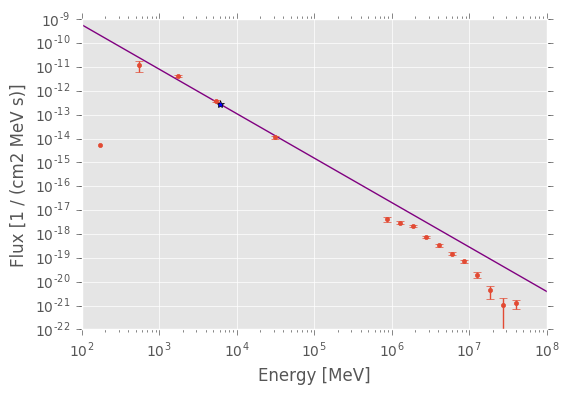

In [9]:
# Defining units
opts = dict(energy_unit='MeV', flux_unit='cm-2 s-1 MeV-1')

source_3fgl.spectral_model.plot(combined_energy_range, **opts, color='purple')
# Using the combined energy range to stretch to gamma-cat data

p = source_3fgl.spectral_model.parameters
# Spectral model type is PowerLaw

# Plot reference point
plt.plot(p['reference'].value, p['amplitude'].value, '*', color='b')


plt.errorbar(x=data_combined['e_ref'],
             y = data_combined['dnde'],
             yerr = data_combined['dnde_err'],
             fmt='.'
            )
# # Plot 3FGL flux points
# plt.errorbar(x=data_3fgl['e_ref'],
#              y = data_3fgl['dnde'],
#              yerr = data_3fgl['dnde_err'],
#              fmt='.',
#              color='purple'
#             )

# # Plot gamma-cat flux points
# plt.errorbar(x=data_gammacat['e_ref'],
#              y = data_gammacat['dnde'],
#              yerr = data_gammacat['dnde_err'],
#              fmt='.',
#              color='r'
#             )

## Likelihood function - chi2

We have to define the chi2 function for this source (given the spectral model is power-law, ecut will not be a parameter)

In [10]:
def chi2(amplitude, index):
    
    dnde_model = source_3fgl.spectral_model.evaluate(
        energy=data_3fgl['e_ref'],
        amplitude=amplitude,
        index=index,
        reference=6018.2392578125 # <-- 3FGL source e_ref minus the units
    ) 

    chi = (data_3fgl['dnde'] - dnde_model) / data_3fgl['dnde_err']
    return np.sum(chi ** 2)

## ML fit with Minuit

In [13]:
from iminuit import Minuit

pars = dict(amplitude=2.872970958356369e-13,  #3FGL amplitude value
            index=1.8643473386764526          #3FGL index value
            )

minuit = Minuit(chi2, **pars)

minuit.print_initial_param()
print("^ Initial parameters")

minuit.migrad() # Performs the minimization
print("^ Optimized parameters for best-fit model")

C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: InitialParamWarning: errordef is not given. Default to 1.
C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: InitialParamWarning: Parameter amplitude is floating but does not have initial step size. Assume 1.
C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: InitialParamWarning: Parameter index is floating but does not have initial step size. Assume 1.


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,amplitude,2.87297e-13,1,0,0,,,
2,index,1.86435,1,0,0,,,


^ Initial parameters


C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    amplitude = +0.000000
        index = +1.864347

C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    amplitude = +nan
        index = +1.864347

C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    amplitude = +0.000000
        index = +nan

C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    amplitude = -nan(ind)
        index = -nan(ind)

C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    amplitude = +nan
        index = +nan

C:\Users\arjun_000\Anaconda3\l

FCN = nan 
 TOTAL NCALL = 36 
 NCALLS = 36 
 
 
 EDM = nan 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,amplitude,nan,nan,0,0,,,
2,index,nan,nan,0,0,,,


^ Optimized parameters for best-fit model
